# SEGMENTATION MODEL

### Prepare Library, Parameters, and Dependencies

In [1]:
%pip install -q git+https://github.com/tensorflow/examples.git --quiet

  Preparing metadata (setup.py) ... done


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import os
from tqdm import tqdm

%matplotlib inline

In [3]:
# UNCOMMENT THIS IF YOU USE GOOGLE COLAB

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.14.0
Num GPUs Available:  1


In [5]:
SEG_DATASET = "dataset/iris_needle_seg_dataset"

BATCH_SIZE_SEG = 8
VAL_RATIO_SEG = 0.2
SHUFFLE_BUFFER_SIZE = 10000

IMG_HEIGHT = 128
IMG_WIDTH = 128

SHUFFLE_VALUE = True
AUTOTUNE = tf.data.AUTOTUNE

### Load Dataset

In [6]:
# USE THIS IF YOU USE LOCAL MACHINE

# # Load OG Image Path
# image_path = []
# for root, dirs, files in os.walk(SEG_DATASET + "/train_original/"):
#     for file in files:
#         if file.endswith(".jpg"):
#              image_path.append(os.path.join(root, file))
# print(len(image_path))
# print(image_path[1])

# # Load Mask Image Path
# mask_path = []
# for root, dirs, files in os.walk(SEG_DATASET + "/train_mask/"):
#     for file in files:
#         if file.endswith(".jpg"):
#              mask_path.append(os.path.join(root, file))
# print(len(mask_path))
# print(mask_path[1])

In [7]:
# USE THIS IF YOU USE GOOGLE COLAB

# Load OG Image and Mask Image Path
image_path = []
mask_path = []
for root, dirs, files in os.walk('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_original'):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_mask',file)
        image_path.append(path_og)
        mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(image_path))
print(image_path[1])

print(len(mask_path))
print(mask_path[1])

1476
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_original/SID1500_jpg.rf.f5c7d2a453dc28aa39e1858fca91e955.jpg
1476
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_mask/SID1500_jpg.rf.f5c7d2a453dc28aa39e1858fca91e955.jpg


### Decode Dataset Into Array

In [8]:
# Decode Mask Image
masks = []
for path in tqdm(mask_path):
    mask = tf.io.read_file(path)
    mask_array = tf.image.decode_jpeg(mask, channels=1)
    masks.append(mask_array)

# Decode OG Image
images = []
for path in tqdm(image_path):
    img = tf.io.read_file(path)
    img_array = tf.image.decode_jpeg(img, channels=3)
    images.append(img_array)

100%|██████████| 1476/1476 [00:04<00:00, 349.08it/s]


### Visualize Dataset

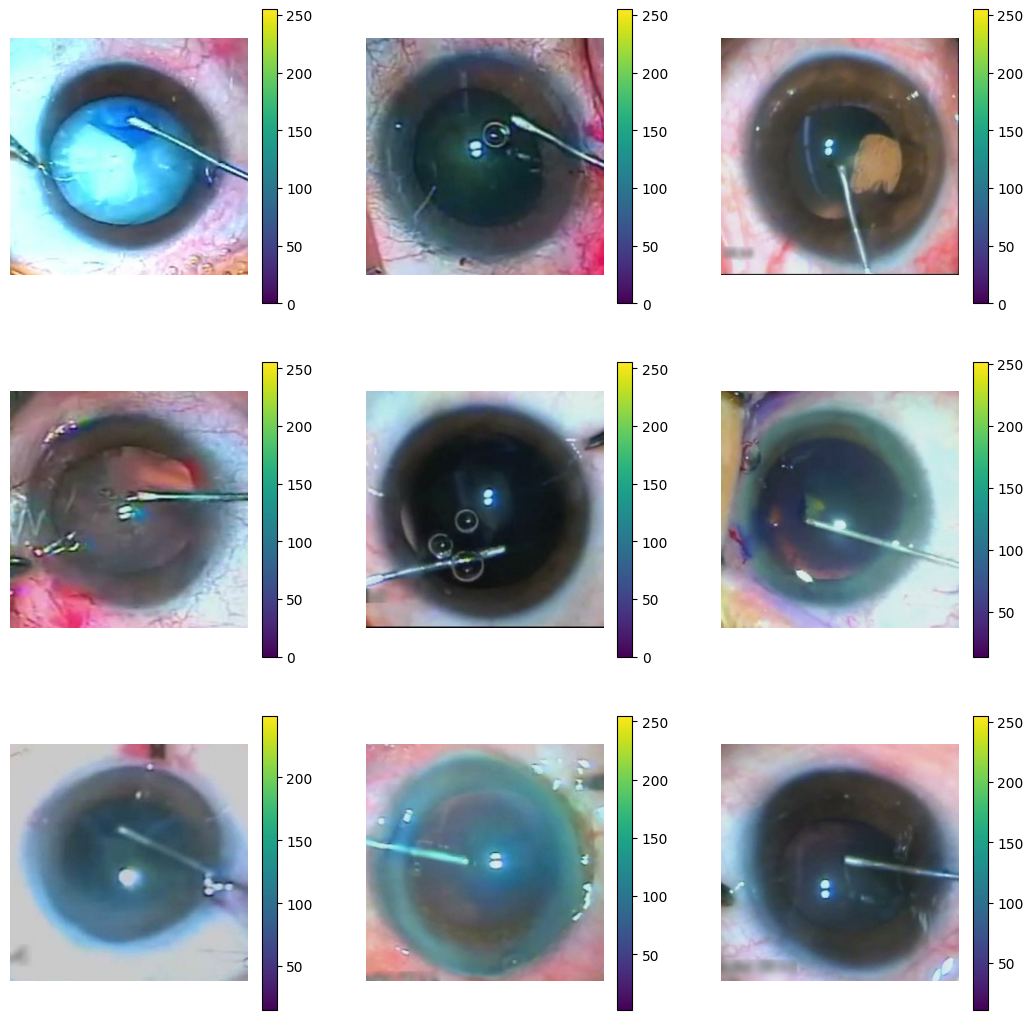

In [9]:
#Visualize Dataset OG Image
plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.colorbar()
    plt.axis("off")

plt.show()

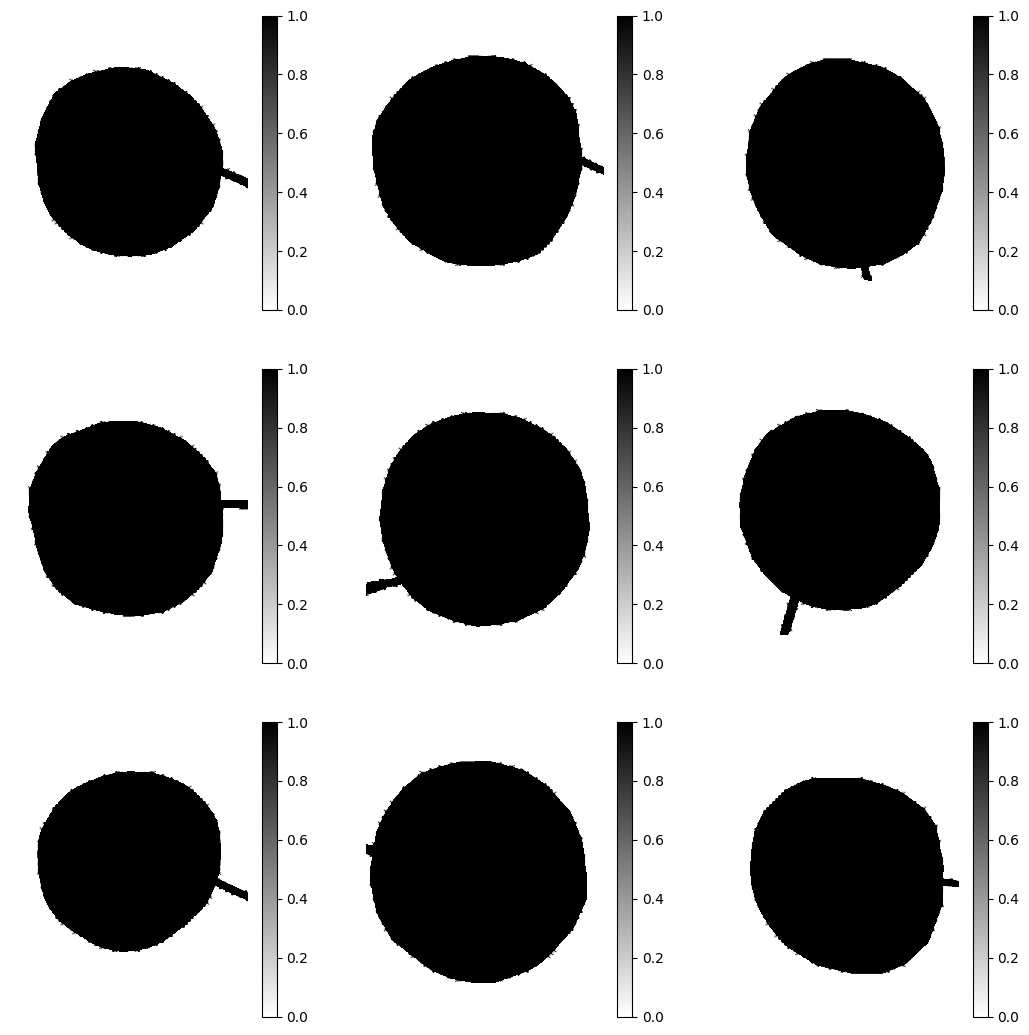

In [10]:
#Visualize Dataset Mask Image
NORM = mpl.colors.Normalize(vmin=0, vmax=1)

plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(masks[i], cmap='binary', norm=NORM)
    plt.colorbar()
    plt.axis("off")

plt.show()

### Resize Dataset

In [11]:
#Resize Dataset OG Image
def resize_image(image):
    image = tf.cast(image, dtype=tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image

#Resize Dataset Mask Image
def resize_mask(mask):
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return mask

X = [resize_image(image) for image in images]
y = [resize_mask(mask) for mask in masks]

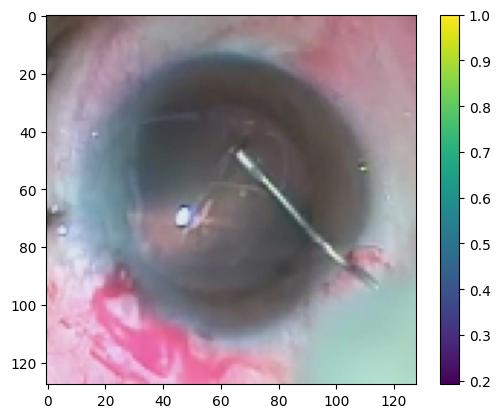

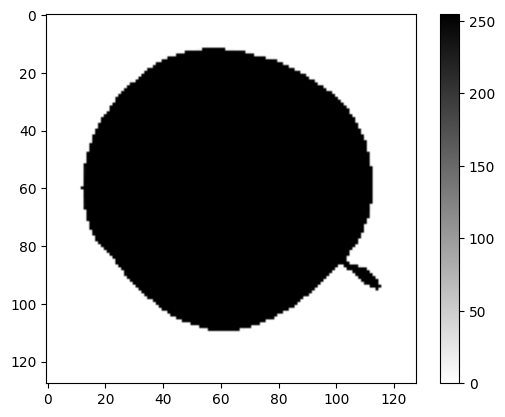

In [12]:
# Visualizing a Resized Image and Respective Mask

# Plot an OG Image
plt.imshow(X[36])
plt.colorbar()
plt.show()

# Plot a Mask
plt.imshow(y[36], cmap='binary')
plt.colorbar()
plt.show()

### Split Dataset & Change Dataset Into TensorFlow Dataset

In [13]:
# Split Dataset With 80/20 Ratio
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_RATIO_SEG, random_state=42)

# Change Dataset Into TensorFlow Dataset
X_train = tf.data.Dataset.from_tensor_slices(X_train)
y_train = tf.data.Dataset.from_tensor_slices(y_train)

X_val = tf.data.Dataset.from_tensor_slices(X_val)
y_val = tf.data.Dataset.from_tensor_slices(y_val)

# Verify the Shapes and Data Types
X_train.element_spec, y_train.element_spec, X_val.element_spec, y_val.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

### Dataset Augmentation

In [14]:
def brightness(image, mask):
    image = tf.image.adjust_brightness(image, 0.1)
    return image, mask

def gamma(image, mask):
    image = tf.image.adjust_gamma(image, 0.1)
    return image, mask

def hue(image, mask):
    image = tf.image.adjust_hue(image, -0.1)
    return image, mask

def crop(image, mask):
    image = tf.image.central_crop(image, 0.7)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return image, mask

def flip_hori(image, mask):
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
    return image, mask

def flip_vert(image, mask):
    image = tf.image.flip_up_down(image)
    mask = tf.image.flip_up_down(mask)
    return image, mask

def rotate(image, mask):
    image = tf.image.rot90(image)
    mask = tf.image.rot90(mask)
    return image, mask

In [15]:
# Zip Dataset
train = tf.data.Dataset.zip((X_train, y_train))
val = tf.data.Dataset.zip((X_val, y_val))

# Perform Data Augmentation
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(gamma))
train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(crop))
train = train.concatenate(train.map(flip_hori))
train = train.concatenate(train.map(flip_vert))
train = train.concatenate(train.map(rotate))

In [16]:
print(train.cardinality())

tf.Tensor(151040, shape=(), dtype=int64)


### Dataset Preparation

In [17]:
train = train.cache().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE_SEG).repeat()
train = train.prefetch(AUTOTUNE)
val = val.batch(BATCH_SIZE_SEG)

### Callback Function

In [18]:
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('val_loss') is not None and logs.get('val_loss') < 0.45:
                print("\nReached <0.25 val_loss so cancelling training!")

                # Stop training once the above condition is met
                self.model.stop_training = True

stop_callback = myCallback()

### Model Architecture #1 (U-Net w/ Transfer Learning & Generative Model pix2pix)

In [19]:
base = keras.applications.DenseNet121(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], include_top=False, weights='imagenet')

29084464/29084464 [==============================] - 2s 0us/step


In [20]:
skip_layer_names = [
    'conv1/relu', # size 64*64
    'pool2_relu',  # size 32*32
    'pool3_relu',  # size 16*16
    'pool4_relu',  # size 8*8
    'relu'        # size 4*4
]

In [21]:
skip_outputs = [base.get_layer(name).output for name in skip_layer_names]

downstack = keras.Model(inputs=base.input, outputs=skip_outputs)

downstack.trainable = True

In [22]:
upstack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [23]:
inputs = keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])

down = downstack(inputs)
out = down[-1]

skips = reversed(down[:-1])

for up, skip in zip(upstack, skips):
    out = up(out)
    out = keras.layers.Concatenate()([out,skip])

out = keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(out)

unet = keras.Model(inputs=inputs, outputs=out)

In [24]:
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 64, 64, 64),         7037504   ['input_2[0][0]']             
                              (None, 32, 32, 256),                                                
                              (None, 16, 16, 512),                                                
                              (None, 8, 8, 1024),                                                 
                              (None, 4, 4, 1024)]                                                 
                                                                                            

### Train Model #1

In [25]:
unet.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [26]:
model_history = unet.fit(
    train,
    validation_data=val,
    steps_per_epoch=(len(X_train) // BATCH_SIZE_SEG),
    validation_steps=len(X_val) // BATCH_SIZE_SEG,
    epochs=50,
    verbose=2,
    # callbacks=[stop_callback]
)

Epoch 1/50
147/147 - 87s - loss: 1.5130 - accuracy: 0.5487 - val_loss: 1.2277 - val_accuracy: 0.6645 - 87s/epoch - 595ms/step
Epoch 2/50
147/147 - 21s - loss: 1.0962 - accuracy: 0.7660 - val_loss: 1.0233 - val_accuracy: 0.8301 - 21s/epoch - 142ms/step
Epoch 3/50
147/147 - 21s - loss: 1.0386 - accuracy: 0.8414 - val_loss: 1.1404 - val_accuracy: 0.8312 - 21s/epoch - 142ms/step
Epoch 4/50
147/147 - 21s - loss: 1.0640 - accuracy: 0.8416 - val_loss: 0.9487 - val_accuracy: 0.8563 - 21s/epoch - 142ms/step
Epoch 5/50
147/147 - 21s - loss: 1.0273 - accuracy: 0.8652 - val_loss: 0.9727 - val_accuracy: 0.8411 - 21s/epoch - 143ms/step
Epoch 6/50
147/147 - 21s - loss: 1.0230 - accuracy: 0.8742 - val_loss: 0.7676 - val_accuracy: 0.8988 - 21s/epoch - 143ms/step
Epoch 7/50
147/147 - 21s - loss: 1.0004 - accuracy: 0.8869 - val_loss: 0.7415 - val_accuracy: 0.9213 - 21s/epoch - 143ms/step
Epoch 8/50
147/147 - 21s - loss: 1.0787 - accuracy: 0.8720 - val_loss: 4.4180 - val_accuracy: 0.5879 - 21s/epoch - 144

### Evaluate Model With Test Dataset

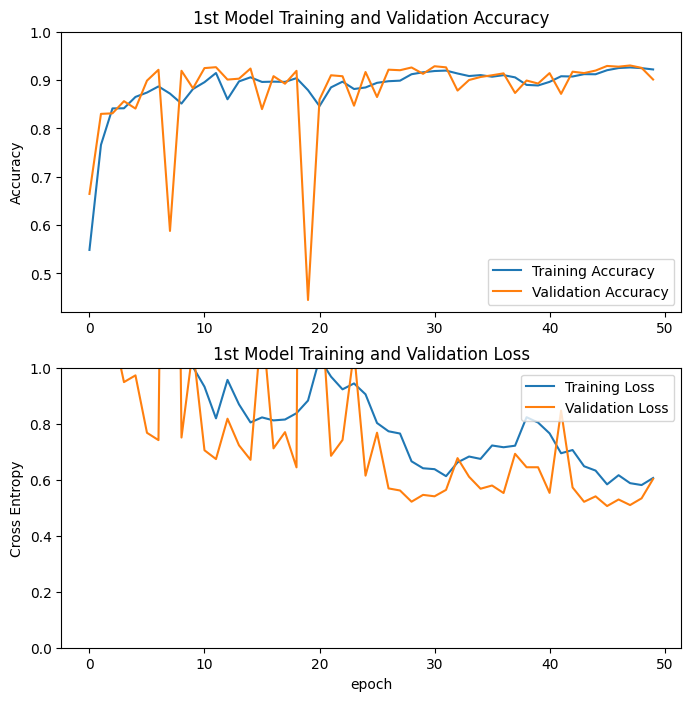

In [27]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('1st Model Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('1st Model Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
# USE THIS IF YOU USE GOOGLE COLAB

# Load OG Image and Mask Image Path
test_image_path = []
test_mask_path = []
for root, dirs, files in os.walk('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_original'):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_mask/',file)
        test_image_path.append(path_og)
        test_mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(test_image_path))
print(test_image_path[1])

print(len(test_mask_path))
print(test_mask_path[1])

# Decode Test Mask Image
test_masks = []
for path in tqdm(test_mask_path):
    mask = tf.io.read_file(path)
    mask_array = tf.image.decode_jpeg(mask, channels=1)
    test_masks.append(mask_array)

# Decode Test OG Image
test_images = []
for path in tqdm(test_image_path):
    img = tf.io.read_file(path)
    img_array = tf.image.decode_jpeg(img, channels=3)
    test_images.append(img_array)

#Resize Test OG Image
def resize_image(image):
    image = tf.cast(image, dtype=tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image

#Resize Test Mask Image
def resize_mask(mask):
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return mask

X = [resize_image(image) for image in test_images]
y = [resize_mask(mask) for mask in test_masks]

X_test = tf.data.Dataset.from_tensor_slices(X)
y_test = tf.data.Dataset.from_tensor_slices(y)

# Zip Dataset
test = tf.data.Dataset.zip((X_test, y_test))

test = test.batch(BATCH_SIZE_SEG)

129
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_original/SID0635_jpg.rf.3d96657ecde6f846f158b241fc735110.jpg
129
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_mask/SID0635_jpg.rf.3d96657ecde6f846f158b241fc735110.jpg


100%|██████████| 129/129 [00:00<00:00, 288.24it/s]


In [29]:
loss, accuracy = unet.evaluate(test)

17/17 [==============================] - 2s 141ms/step - loss: 0.3471 - accuracy: 0.9234


1/1 [==============================] - 2s 2s/step


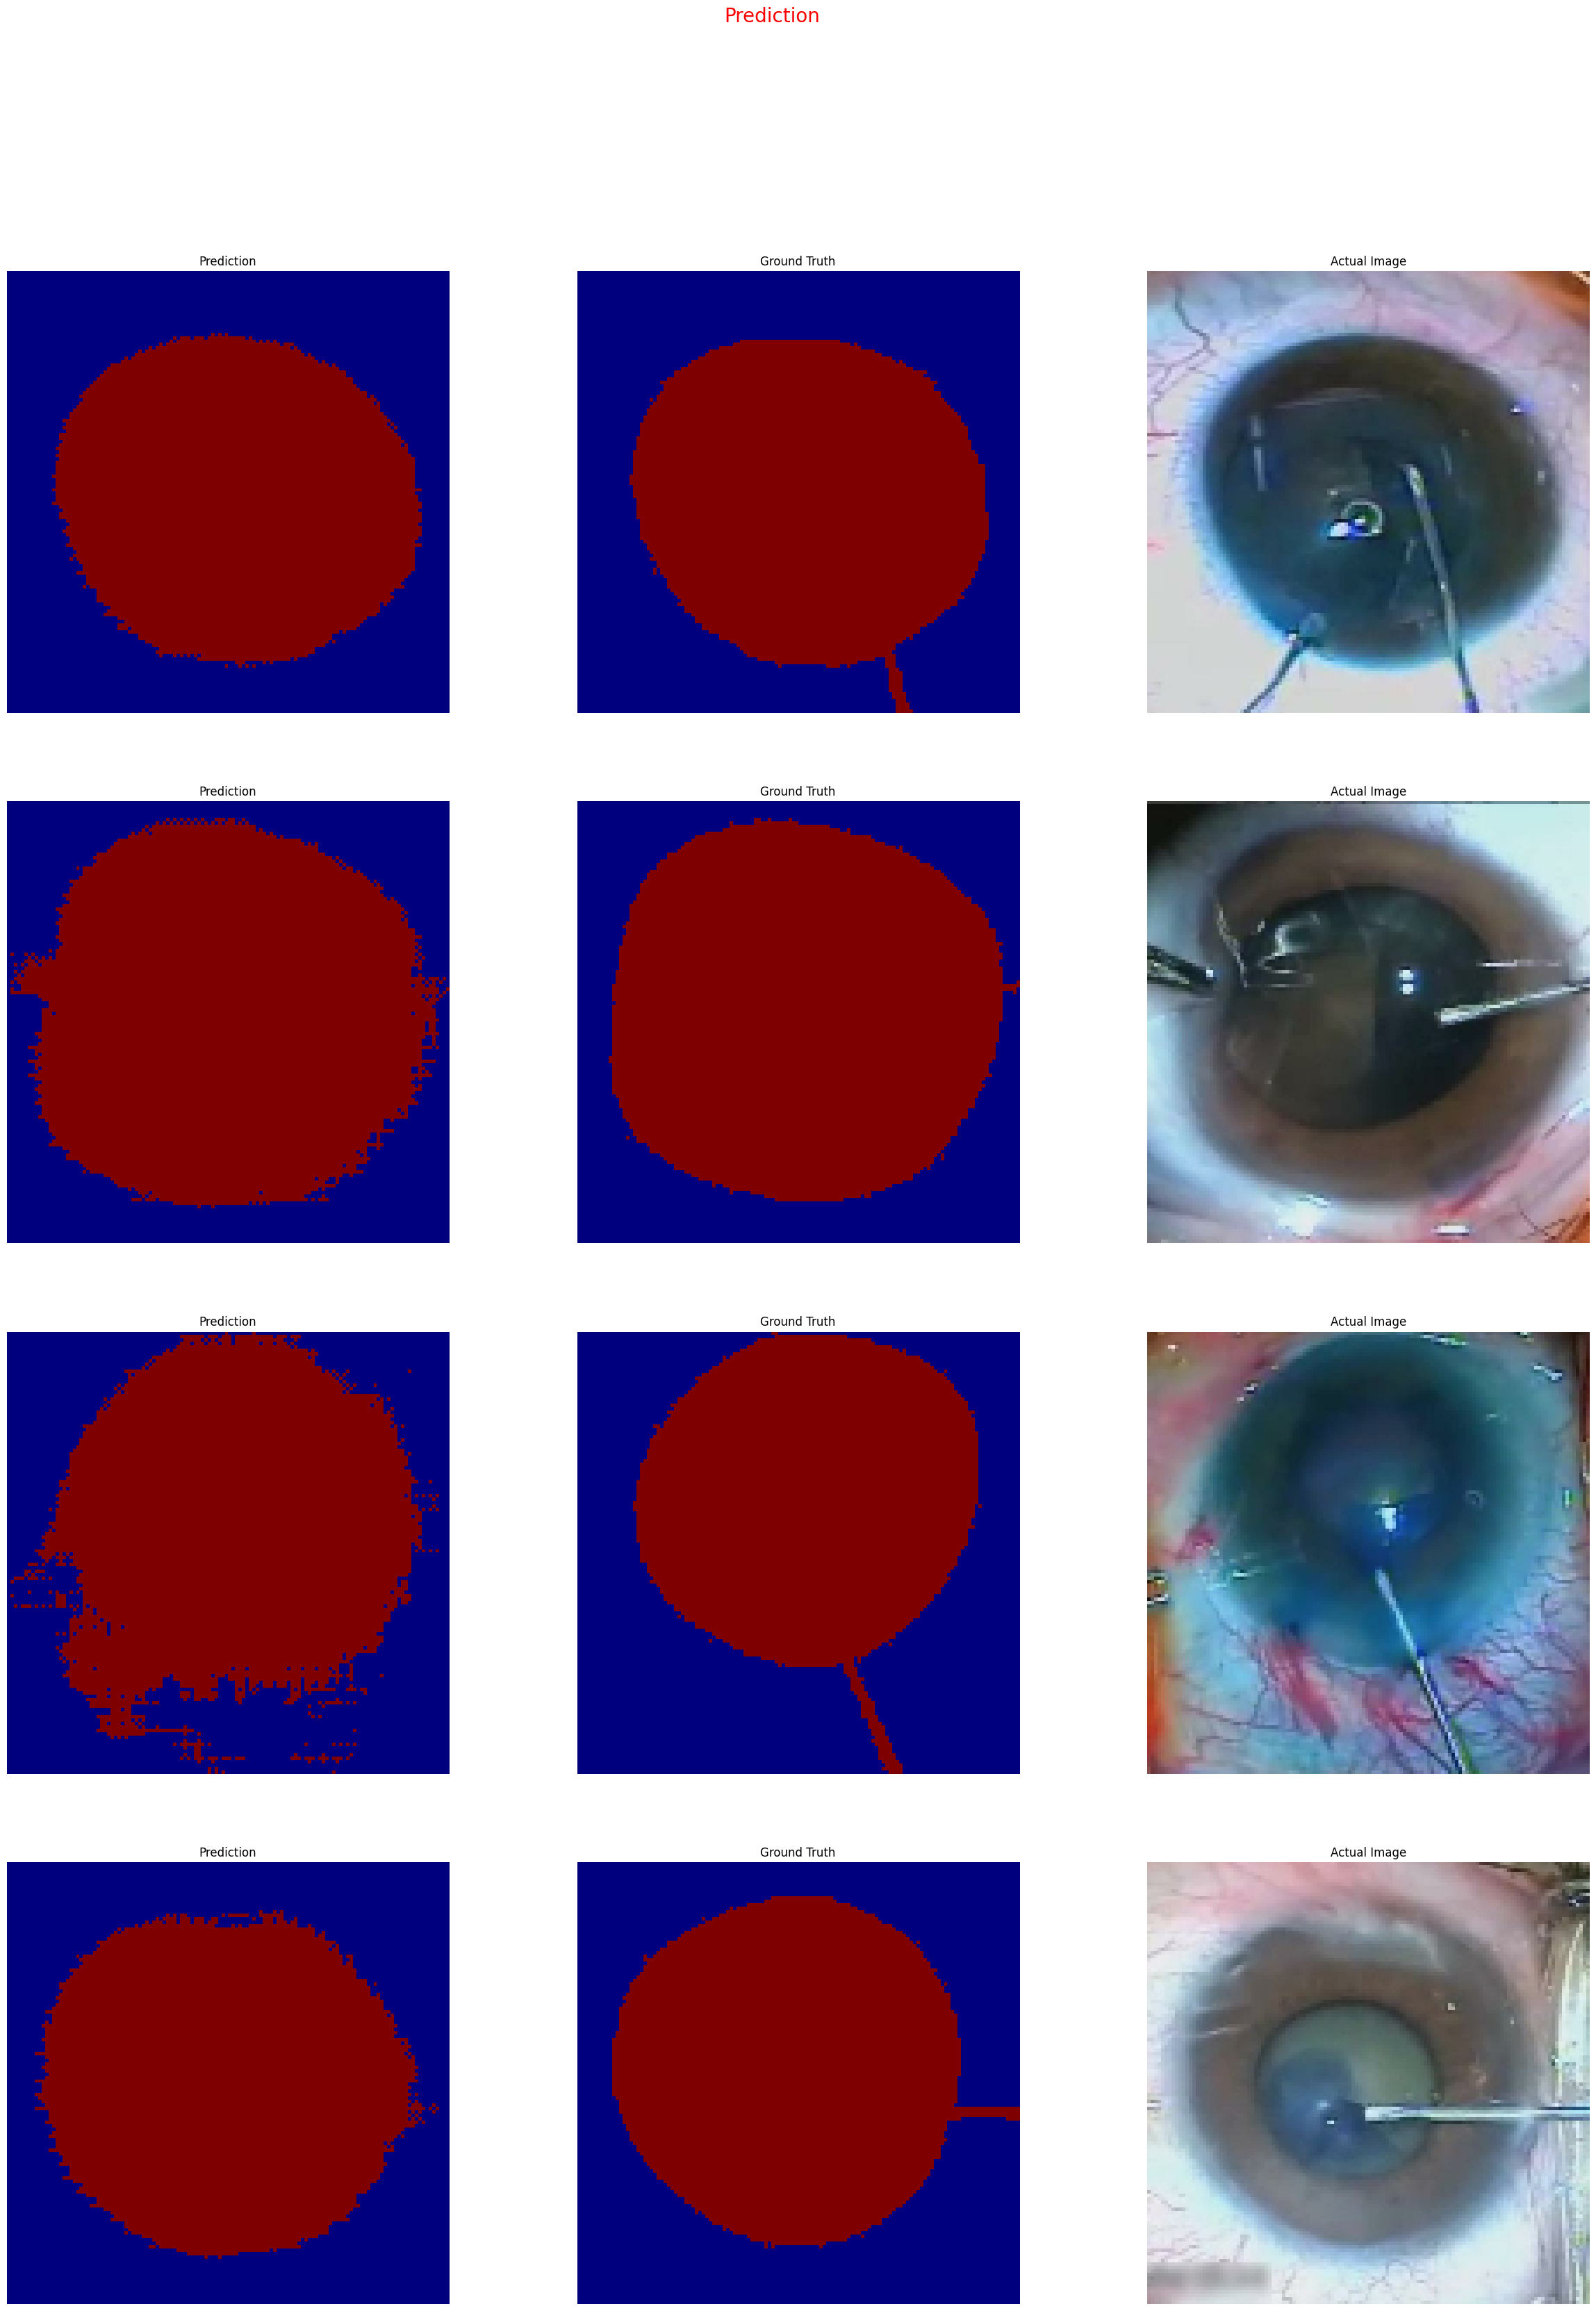

In [30]:
# Select a Validation Data Batch
img, mask = next(iter(test))

# Make Prediction
pred = unet.predict(img)
plt.figure(figsize=(30,38))

k = 0
for i in pred:
    # Plot the Predicted Mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction')

    # Plot the Groundtruth Mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Ground Truth')

    # Plot the Actual Image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break

plt.suptitle('Prediction', color='red', size=20)
plt.show()

###

### Test With Cataract Dataset

In [31]:
# USE THIS IF YOU USE GOOGLE COLAB

# Load OG Image and Mask Image Path
test_image_path = []
test_mask_path = []
for root, dirs, files in os.walk('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/'):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/',file)
        test_image_path.append(path_og)
        test_mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(test_image_path))
print(test_image_path[1])

print(len(test_mask_path))
print(test_mask_path[1])

# Decode Test Mask Image
test_masks = []
for path in tqdm(test_mask_path):
    mask = tf.io.read_file(path)
    mask_array = tf.image.decode_jpeg(mask, channels=1)
    test_masks.append(mask_array)

# Decode Test OG Image
test_images = []
for path in tqdm(test_image_path):
    img = tf.io.read_file(path)
    img_array = tf.image.decode_jpeg(img, channels=3)
    test_images.append(img_array)

#Resize Test OG Image
def resize_image(image):
    image = tf.cast(image, dtype=tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image

#Resize Test Mask Image
def resize_mask(mask):
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return mask

X = [resize_image(image) for image in test_images]
y = [resize_mask(mask) for mask in test_masks]

X_test = tf.data.Dataset.from_tensor_slices(X)
y_test = tf.data.Dataset.from_tensor_slices(y)

# Zip Dataset
test = tf.data.Dataset.zip((X_test, y_test))

test = test.batch(BATCH_SIZE_SEG)

4
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/mild_46.png
4
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/mild_46.png


100%|██████████| 4/4 [00:00<00:00, 285.54it/s]


1/1 [==============================] - 2s 2s/step


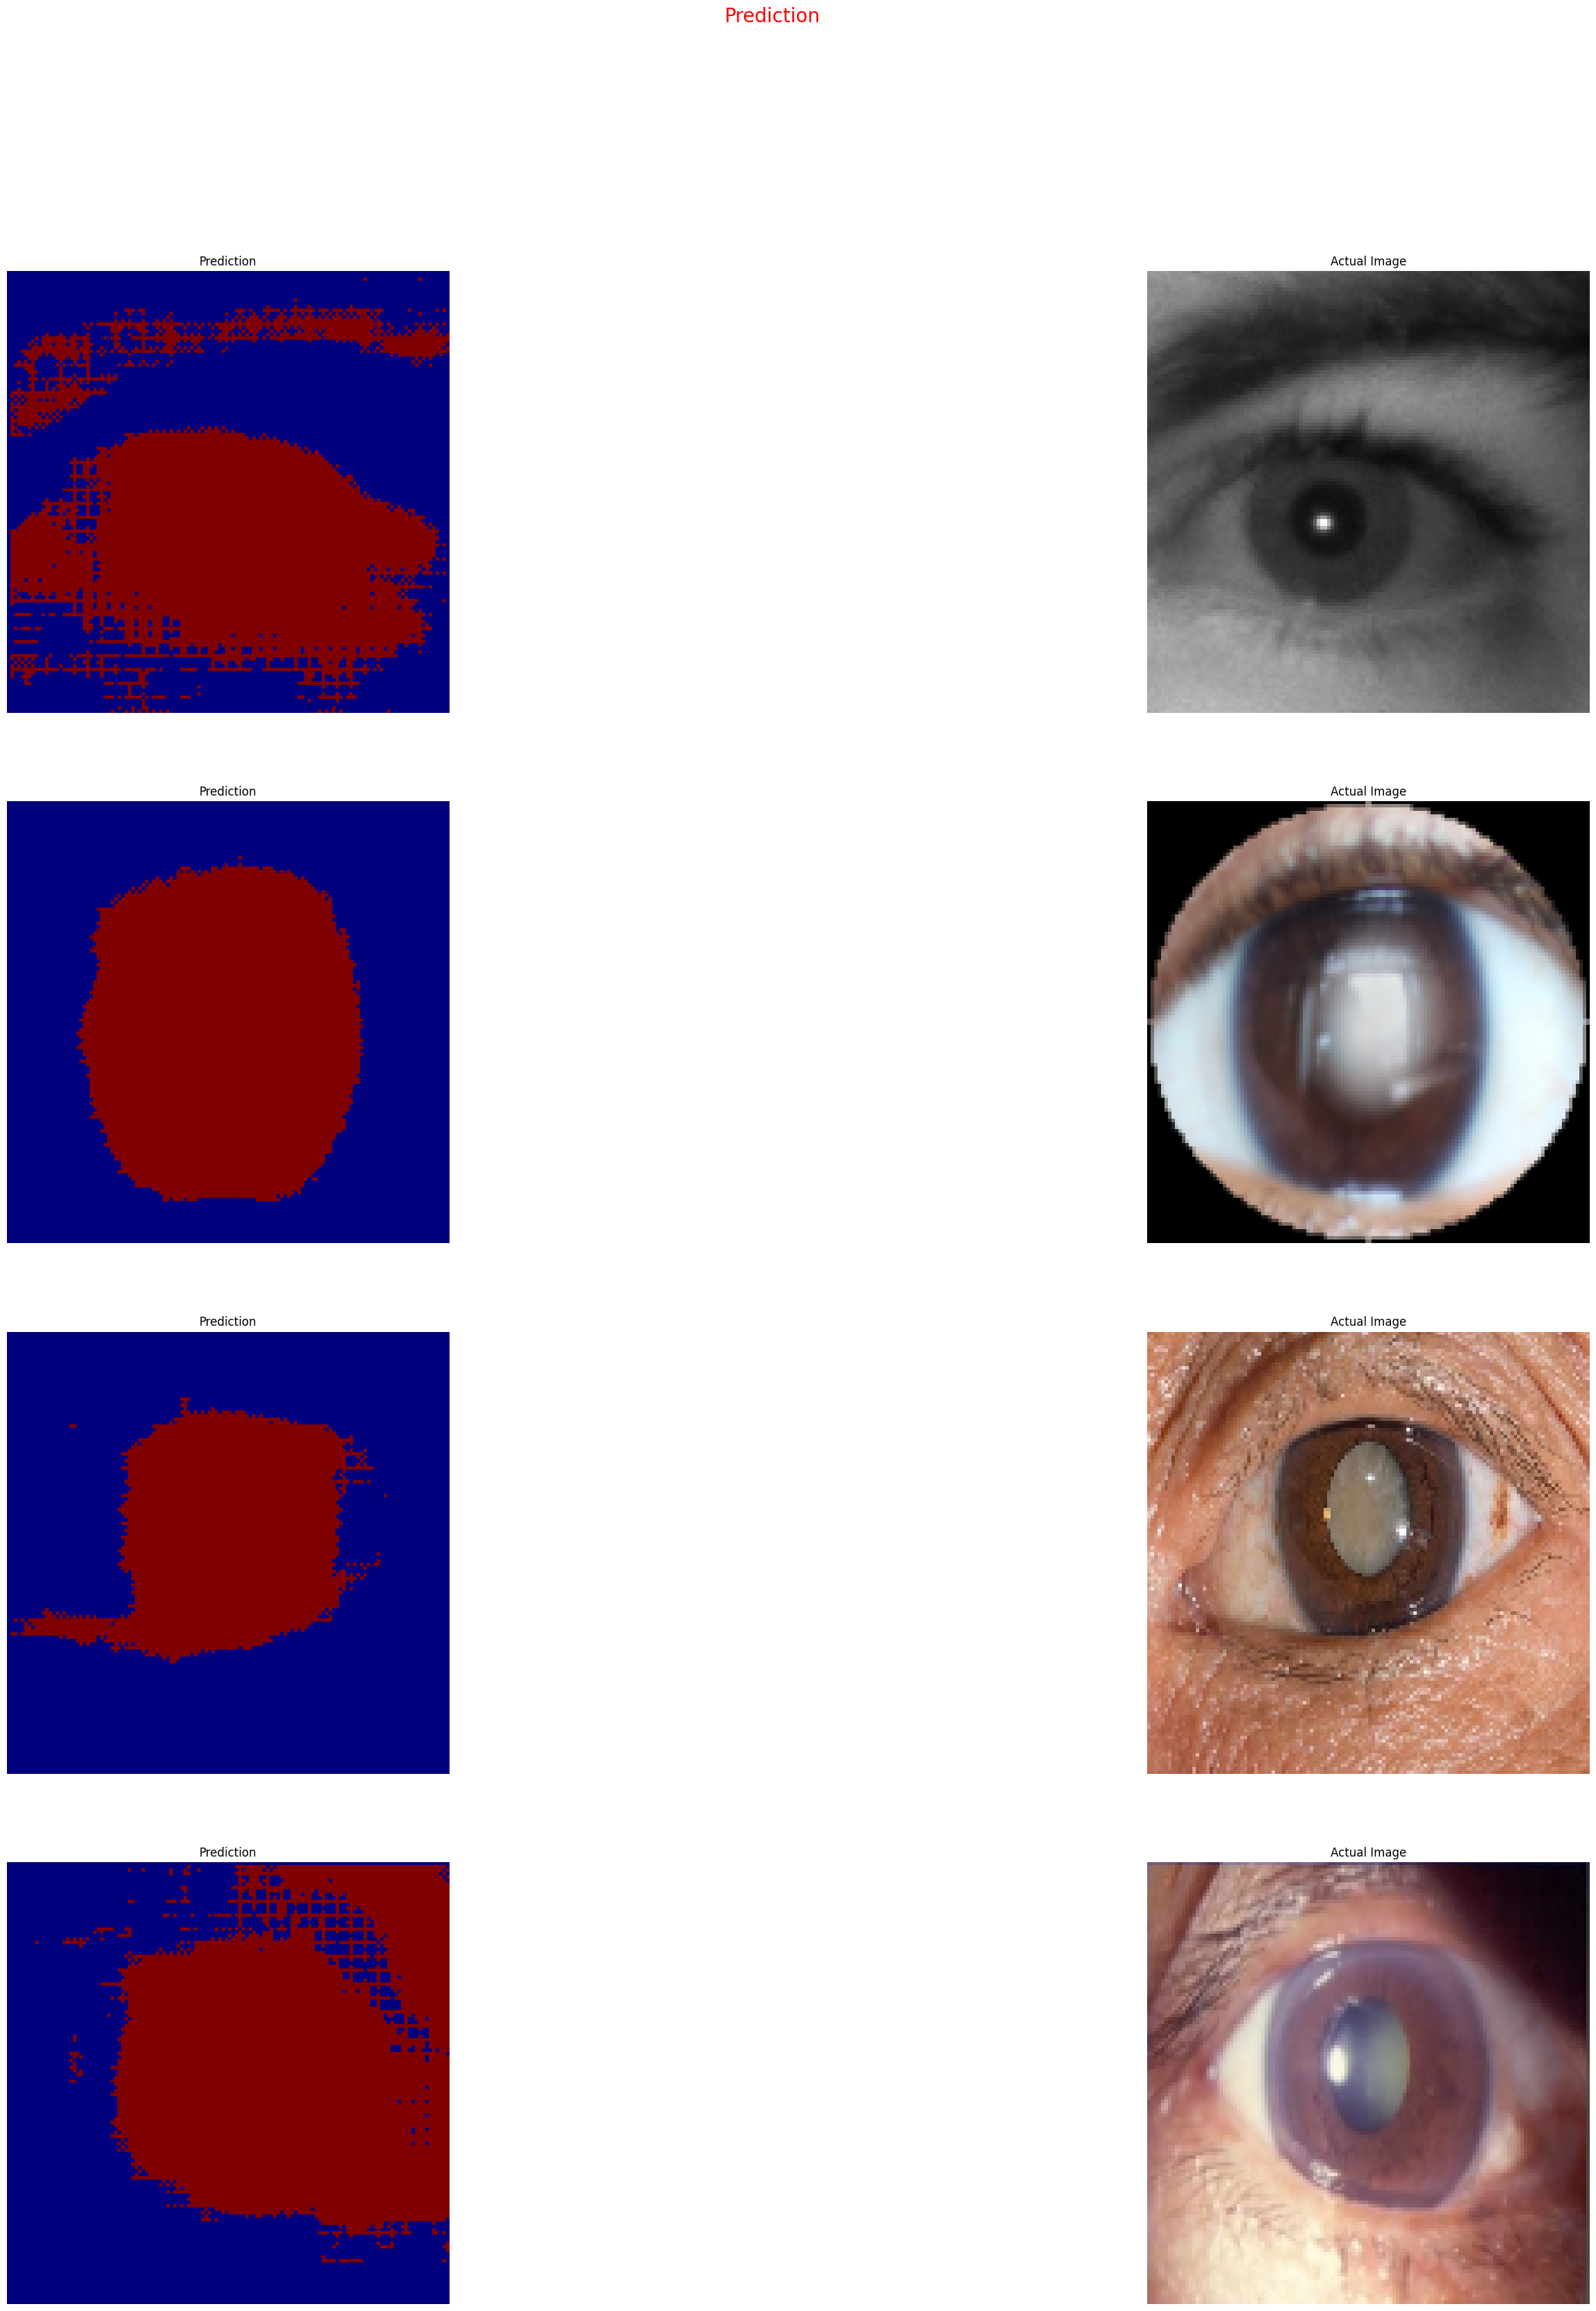

In [32]:
# Select a Validation Data Batch
img, mask = next(iter(test))

# Make Prediction
pred = unet.predict(img)
plt.figure(figsize=(30,38))

k = 0
for i in pred:
    # Plot the Predicted Mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction')

    # Plot the Actual Image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break

plt.suptitle('Prediction', color='red', size=20)
plt.show()

### Model Architecture #2 (U-Net Vanilla)

In [33]:
kernel_initializer =  'he_normal'

# Build Contraction Path
input_layer = keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 3), name="input_image")
c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(input_layer)
c1 = keras.layers.Dropout(0.1)(c1)
c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
p1 = keras.layers.MaxPooling2D((2, 2))(c1)

c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
c2 = keras.layers.Dropout(0.1)(c2)
c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
p2 = keras.layers.MaxPooling2D((2, 2))(c2)

c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
c3 = keras.layers.Dropout(0.2)(c3)
c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
p3 = keras.layers.MaxPooling2D((2, 2))(c3)

c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
c4 = keras.layers.Dropout(0.2)(c4)
c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
p4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
c5 = keras.layers.Dropout(0.3)(c5)
c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

# Build Expansive Path
u6 = keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = keras.layers.concatenate([u6, c4])
c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
c6 = keras.layers.Dropout(0.2)(c6)
c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

u7 = keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = keras.layers.concatenate([u7, c3])
c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
c7 = keras.layers.Dropout(0.2)(c7)
c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

u8 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = keras.layers.concatenate([u8, c2])
c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
c8 = keras.layers.Dropout(0.1)(c8)
c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

u9 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = keras.layers.concatenate([u9, c1], axis=3)
c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
c9 = keras.layers.Dropout(0.1)(c9)
c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
output = keras.layers.Conv2D(256, (1,1), activation='sigmoid')(c9)

unet = keras.Model(inputs=[input_layer], outputs=[output])

In [34]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_image[0][0]']         
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['dropout[0][0]']             
                                                                                            

### Train Model #2

In [35]:
unet.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [36]:
model_history = unet.fit(
    train,
    validation_data=val,
    steps_per_epoch=(len(X_train) // BATCH_SIZE_SEG),
    validation_steps=len(X_val) // BATCH_SIZE_SEG,
    epochs=50,
    verbose=2,
    # callbacks=[stop_callback]
)

Epoch 1/50
147/147 - 42s - loss: 1.3851 - accuracy: 0.6582 - val_loss: 0.6011 - val_accuracy: 0.8764 - 42s/epoch - 285ms/step
Epoch 2/50
147/147 - 28s - loss: 0.6581 - accuracy: 0.8299 - val_loss: 0.4807 - val_accuracy: 0.8915 - 28s/epoch - 193ms/step
Epoch 3/50
147/147 - 28s - loss: 0.6715 - accuracy: 0.8294 - val_loss: 0.5239 - val_accuracy: 0.8825 - 28s/epoch - 193ms/step
Epoch 4/50
147/147 - 28s - loss: 0.6989 - accuracy: 0.8182 - val_loss: 0.5145 - val_accuracy: 0.8727 - 28s/epoch - 193ms/step
Epoch 5/50
147/147 - 28s - loss: 0.6730 - accuracy: 0.8353 - val_loss: 0.4321 - val_accuracy: 0.9053 - 28s/epoch - 194ms/step
Epoch 6/50
147/147 - 28s - loss: 0.6227 - accuracy: 0.8584 - val_loss: 0.4404 - val_accuracy: 0.8978 - 28s/epoch - 194ms/step
Epoch 7/50
147/147 - 28s - loss: 0.6156 - accuracy: 0.8636 - val_loss: 0.4327 - val_accuracy: 0.8974 - 28s/epoch - 194ms/step
Epoch 8/50
147/147 - 28s - loss: 0.5885 - accuracy: 0.8750 - val_loss: 0.4013 - val_accuracy: 0.9067 - 28s/epoch - 194

### Evaluate Model With Test Dataset

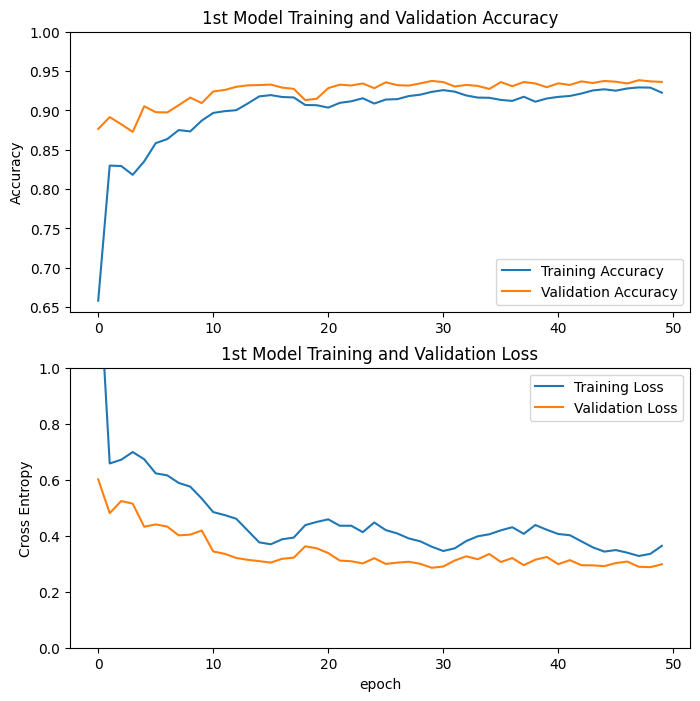

In [37]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('1st Model Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('1st Model Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
# USE THIS IF YOU USE GOOGLE COLAB

# Load OG Image and Mask Image Path
test_image_path = []
test_mask_path = []
for root, dirs, files in os.walk('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_original'):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_mask/',file)
        test_image_path.append(path_og)
        test_mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(test_image_path))
print(test_image_path[1])

print(len(test_mask_path))
print(test_mask_path[1])

# Decode Test Mask Image
test_masks = []
for path in tqdm(test_mask_path):
    mask = tf.io.read_file(path)
    mask_array = tf.image.decode_jpeg(mask, channels=1)
    test_masks.append(mask_array)

# Decode Test OG Image
test_images = []
for path in tqdm(test_image_path):
    img = tf.io.read_file(path)
    img_array = tf.image.decode_jpeg(img, channels=3)
    test_images.append(img_array)

#Resize Test OG Image
def resize_image(image):
    image = tf.cast(image, dtype=tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image

#Resize Test Mask Image
def resize_mask(mask):
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return mask

X = [resize_image(image) for image in test_images]
y = [resize_mask(mask) for mask in test_masks]

X_test = tf.data.Dataset.from_tensor_slices(X)
y_test = tf.data.Dataset.from_tensor_slices(y)

# Zip Dataset
test = tf.data.Dataset.zip((X_test, y_test))

test = test.batch(BATCH_SIZE_SEG)

129
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_original/SID0635_jpg.rf.3d96657ecde6f846f158b241fc735110.jpg
129
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_mask/SID0635_jpg.rf.3d96657ecde6f846f158b241fc735110.jpg


100%|██████████| 129/129 [00:00<00:00, 335.65it/s]


In [39]:
loss, accuracy = unet.evaluate(test)

17/17 [==============================] - 2s 112ms/step - loss: 0.1716 - accuracy: 0.9544


1/1 [==============================] - 0s 334ms/step


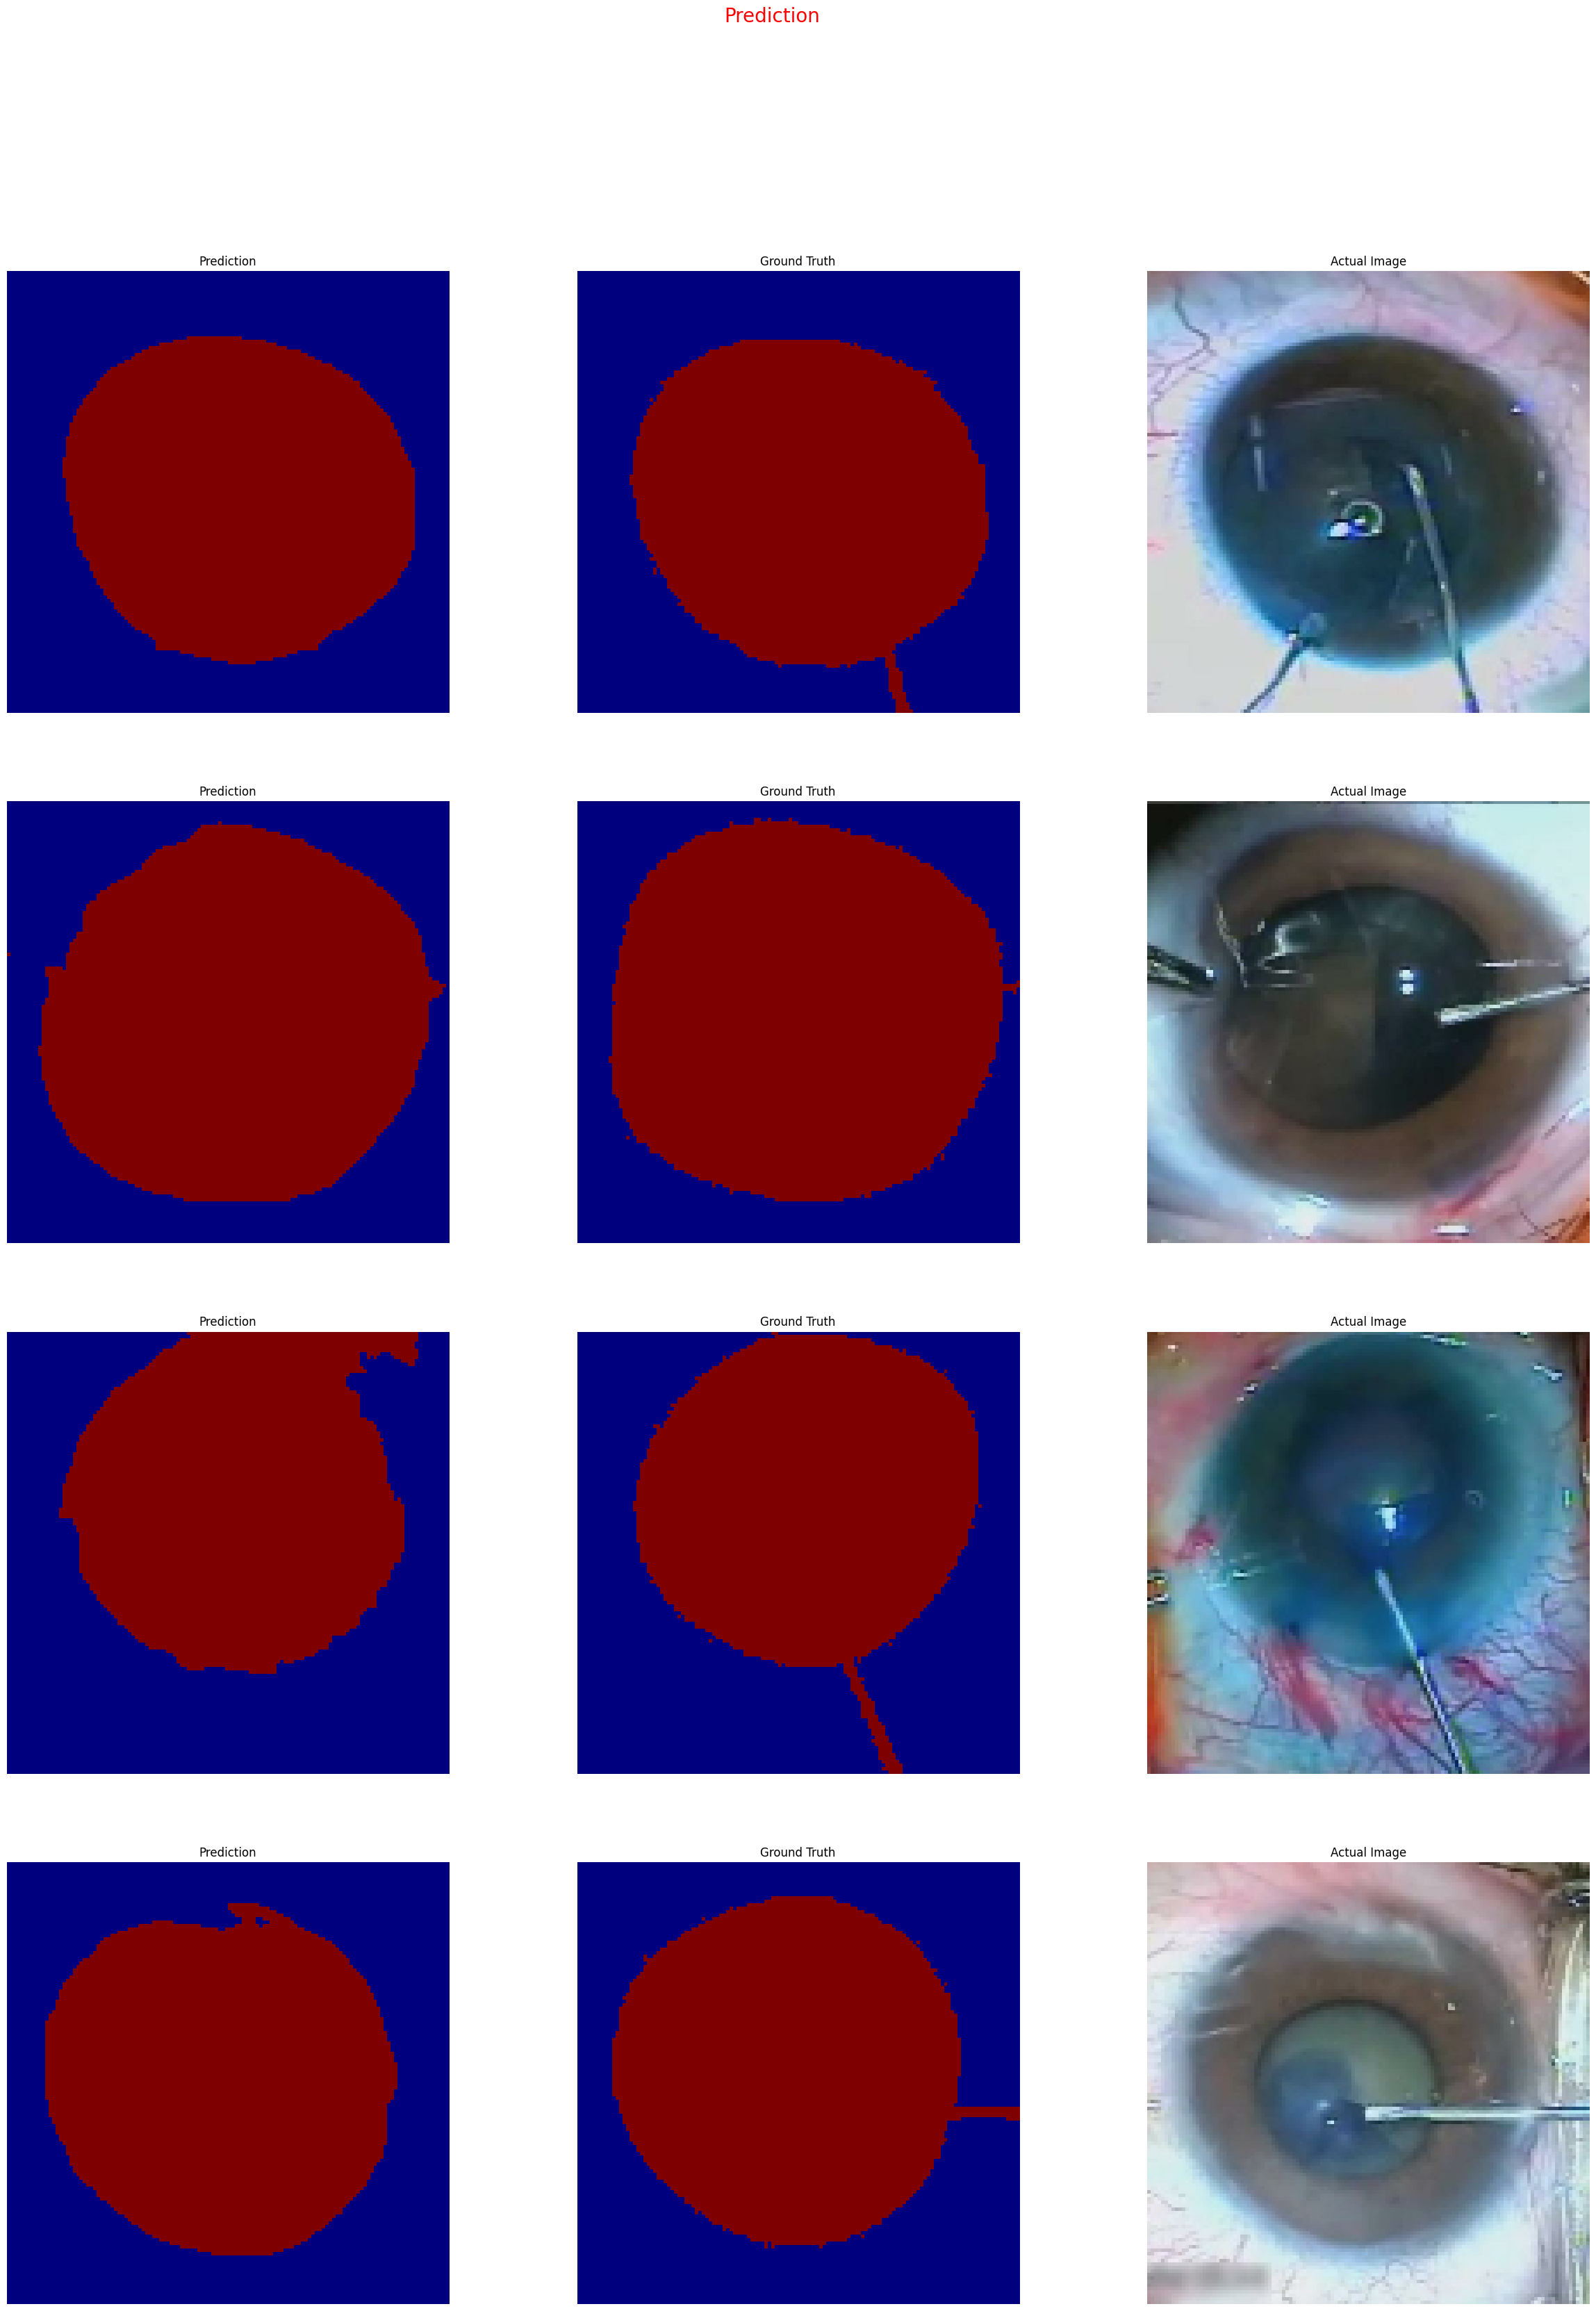

In [40]:
# Select a Validation Data Batch
img, mask = next(iter(test))

# Make Prediction
pred = unet.predict(img)
plt.figure(figsize=(30,38))

k = 0
for i in pred:
    # Plot the Predicted Mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction')

    # Plot the Groundtruth Mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Ground Truth')

    # Plot the Actual Image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break

plt.suptitle('Prediction', color='red', size=20)
plt.show()

### Test With Cataract Dataset

In [41]:
# USE THIS IF YOU USE GOOGLE COLAB

# Load OG Image and Mask Image Path
test_image_path = []
test_mask_path = []
for root, dirs, files in os.walk('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/'):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/',file)
        test_image_path.append(path_og)
        test_mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(test_image_path))
print(test_image_path[1])

print(len(test_mask_path))
print(test_mask_path[1])

# Decode Test Mask Image
test_masks = []
for path in tqdm(test_mask_path):
    mask = tf.io.read_file(path)
    mask_array = tf.image.decode_jpeg(mask, channels=1)
    test_masks.append(mask_array)

# Decode Test OG Image
test_images = []
for path in tqdm(test_image_path):
    img = tf.io.read_file(path)
    img_array = tf.image.decode_jpeg(img, channels=3)
    test_images.append(img_array)

#Resize Test OG Image
def resize_image(image):
    image = tf.cast(image, dtype=tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image

#Resize Test Mask Image
def resize_mask(mask):
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return mask

X = [resize_image(image) for image in test_images]
y = [resize_mask(mask) for mask in test_masks]

X_test = tf.data.Dataset.from_tensor_slices(X)
y_test = tf.data.Dataset.from_tensor_slices(y)

# Zip Dataset
test = tf.data.Dataset.zip((X_test, y_test))

test = test.batch(BATCH_SIZE_SEG)

4
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/mild_46.png
4
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/mild_46.png


100%|██████████| 4/4 [00:00<00:00, 278.89it/s]


1/1 [==============================] - 1s 1s/step


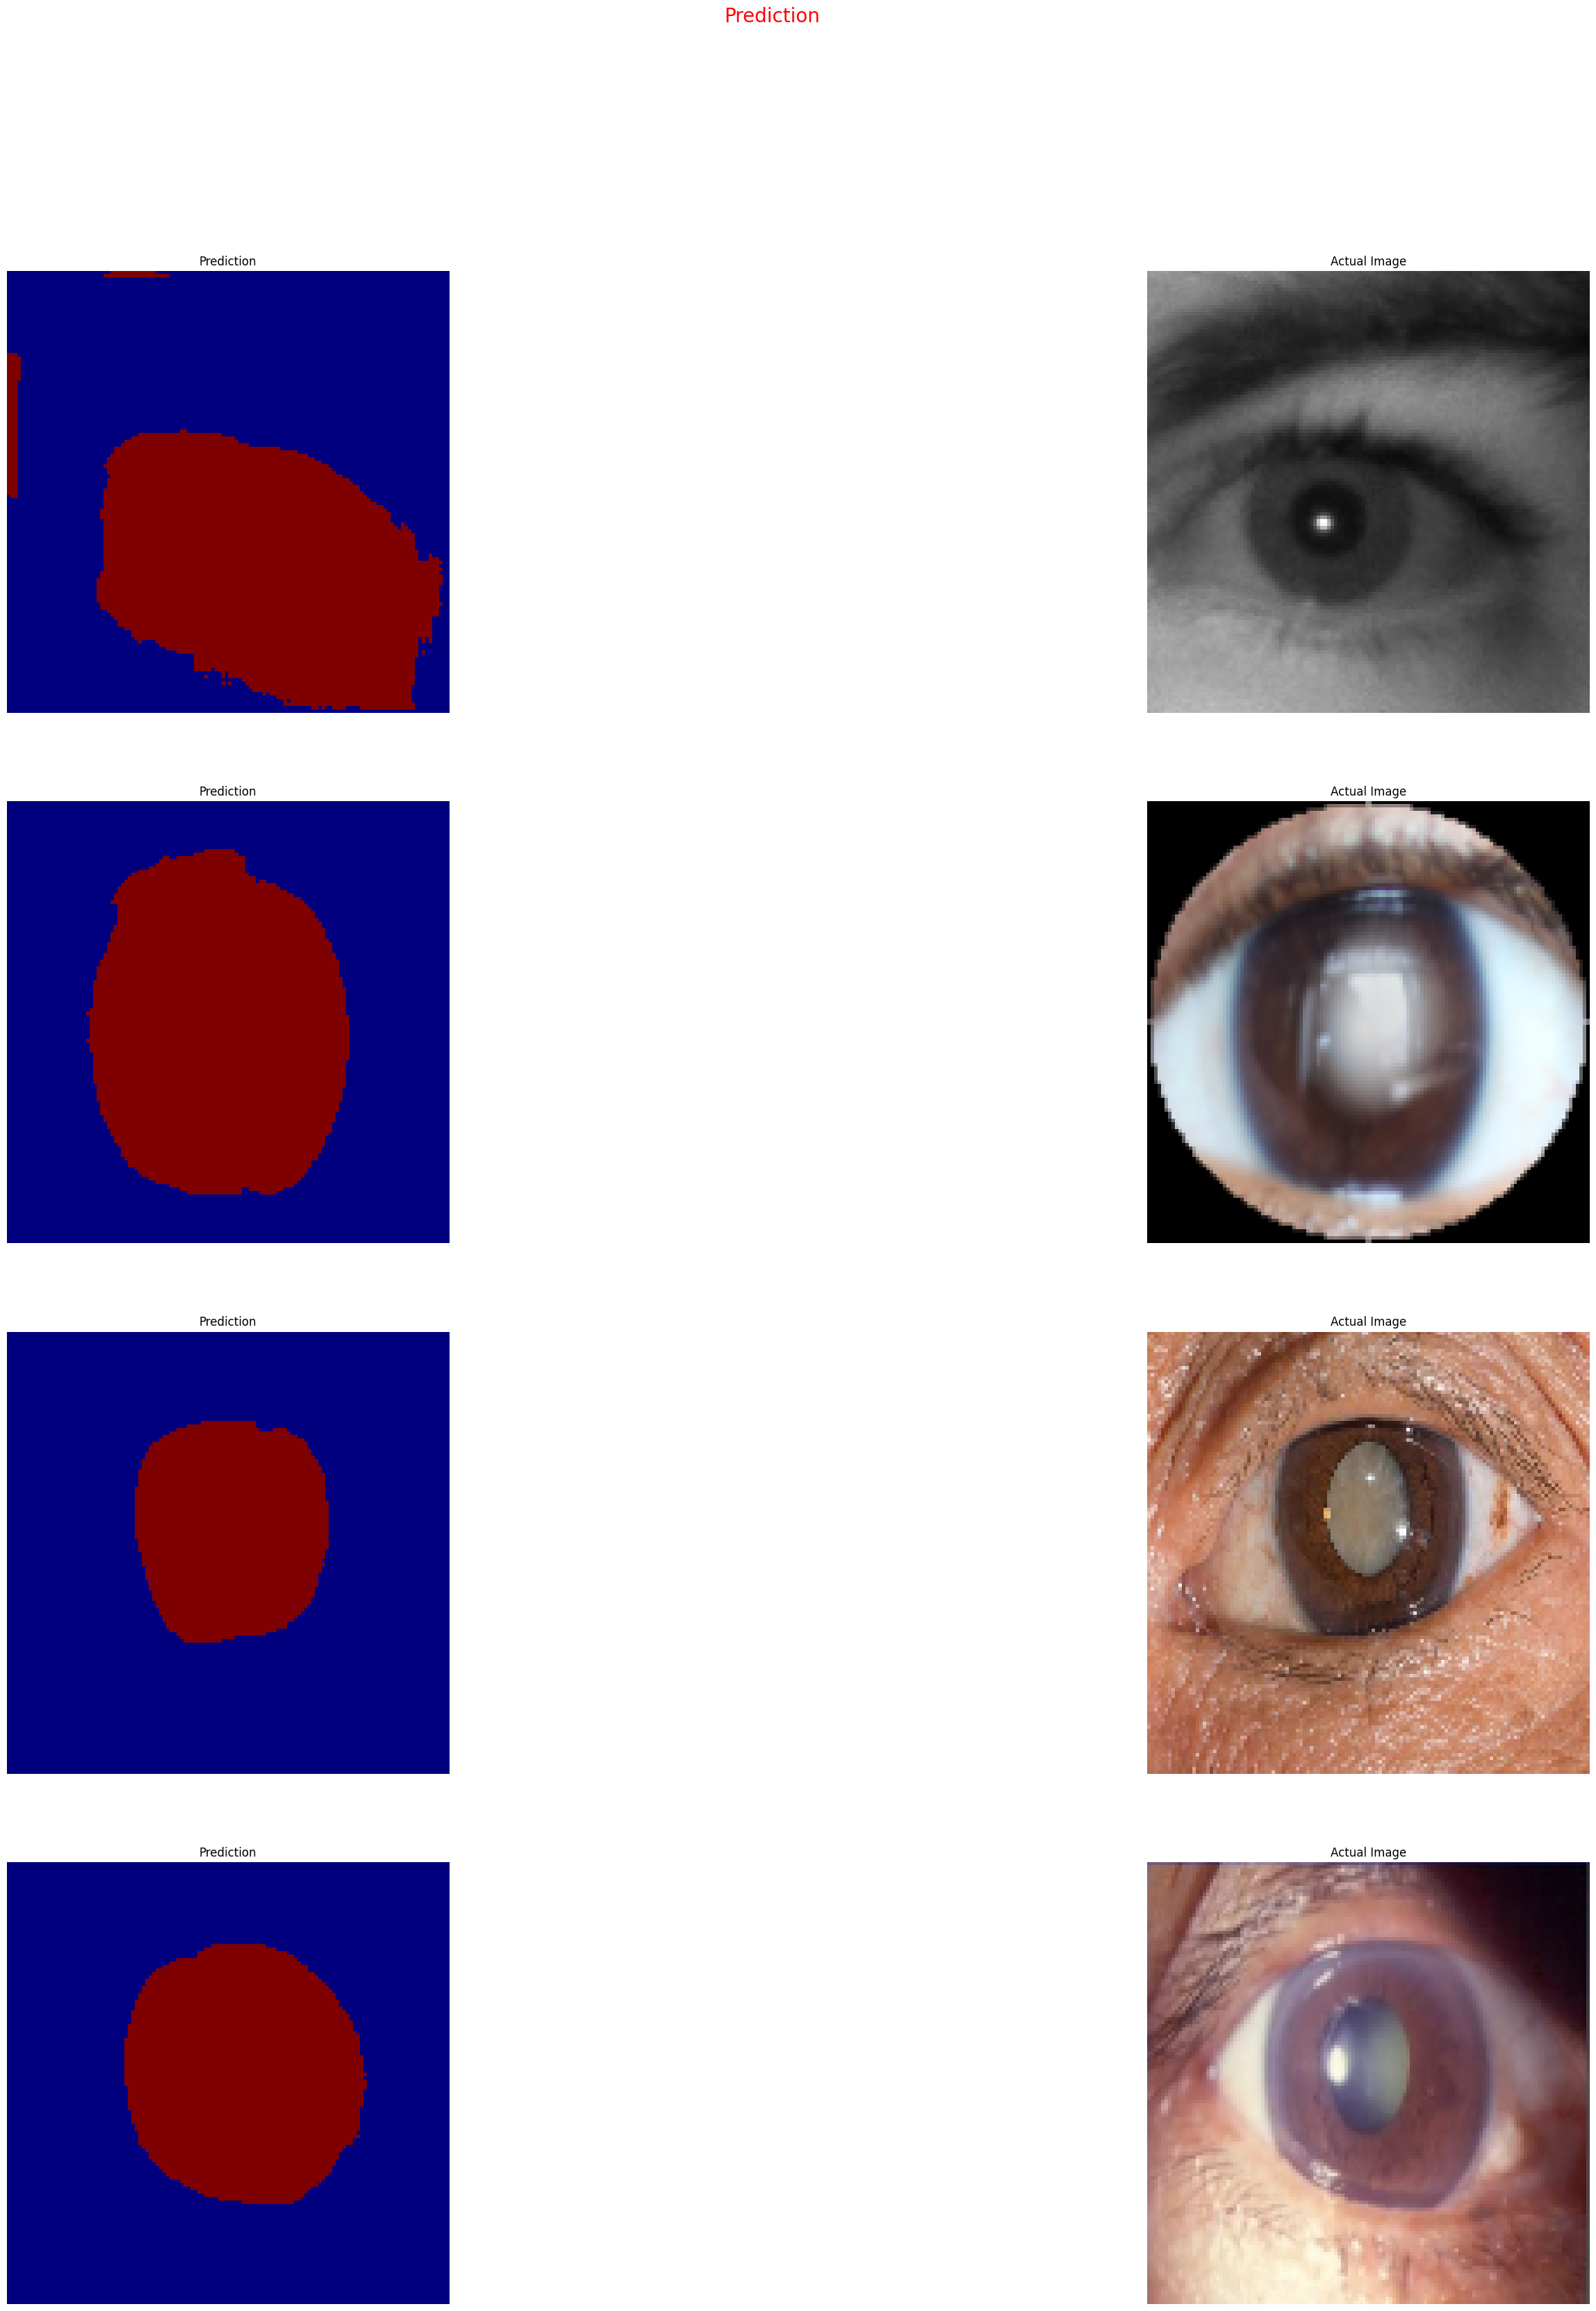

In [42]:
# Select a Validation Data Batch
img, mask = next(iter(test))

# Make Prediction
pred = unet.predict(img)
plt.figure(figsize=(30,38))

k = 0
for i in pred:
    # Plot the Predicted Mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction')

    # Plot the Actual Image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break

plt.suptitle('Prediction', color='red', size=20)
plt.show()